In [1]:
import os
import matplotlib.pyplot as plt

In [2]:
import json
def read_file(f):
    with open(f, 'r') as f:
        return json.load(f)

In [3]:
def parse_json(f):
    data = read_file(f)
    # get all values where key contains 'english_gender' or 'open' in a new dict 
    english = {k: v for k, v in data['results'].items() if 'english_gender' in k}
    # get only the pct_stereotype key from the new dict
    english = {k: v['pct_stereotype'] for k, v in english.items()}
    # get all values where key contains 'lambada_openai' in a new dict
    openai = {k: v for k, v in data['results'].items() if 'lambada_openai' in k}
    # get only the ppl key from the new dict
    openai = {k: v['ppl'] for k, v in openai.items()}
    return english

In [4]:
print(os.listdir('../results/json/v1.1-evals/'))

['pythia-1.4b', 'pythia-1.4b-1MtokBS', 'pythia-1.4b-deduped', 'pythia-12b', 'pythia-12b-deduped', 'pythia-160m', 'pythia-160m-0.5MtokBS', 'pythia-160m-deduped', 'pythia-1b-0.5MtokBS', 'pythia-1b-bf16', 'pythia-1b-deduped', 'pythia-2.8b', 'pythia-2.8b-deduped', 'pythia-410m', 'pythia-410m-0.5MtokBS', 'pythia-410m-deduped', 'pythia-6.9b', 'pythia-6.9b-deduped', 'pythia-70m', 'pythia-70m-0.25MtokBS', 'pythia-70m-deduped']


In [5]:
os.listdir('../results/json/v1.1-evals/')

sizes = ['70m', '410m', '1.4b', '6.9b']
deduped_data = []

for size in sizes:
    base_name = '../results/json/v1.1-evals/pythia-{}-deduped'.format(size)
    baseline_folder = base_name + '/baseline'
    intervention_folder = base_name + '/intervention'
    zero_shot_folder = base_name + '/zero-shot'
    long_intervention_folder = None
    long_intervention = None
    baseline = os.listdir(baseline_folder)
    intervention = os.listdir(intervention_folder)

    if size == '1.4b':
        long_intervention_folder = base_name + '/intervention'
        long_intervention = os.listdir(long_intervention_folder)
        # filter files which have long_step in their name
        long_intervention = [f for f in long_intervention if 'long_step' in f]
        intervention_folder = base_name + '/intervention'
        intervention = os.listdir(intervention_folder)
        # filter files which do not have long_step in their name
        intervention = [f for f in intervention if 'long_step' not in f]
    deduped_data.append({
        'size': size,
        'baseline_folder': baseline_folder,
        'baseline': os.listdir(baseline_folder),
        'intervention_folder': intervention_folder,
        'intervention': os.listdir(intervention_folder),
        'zero_shot_folder': zero_shot_folder,
        'zero_shot': os.listdir(zero_shot_folder),
        'long_intervention_folder': long_intervention_folder,
        'long_intervention': long_intervention
    })


In [6]:
task_names = ['crows_pairs_english_gender']

In [7]:
pythia_res = {}
intervened_res = {}
long_intervened_res = {}
for i in deduped_data:
    for baseline_file in i['baseline']:
        # print(baseline_file)
        # print(i['baseline_folder'] + '/' + baseline_file)
        data = parse_json(i['baseline_folder'] + '/' + baseline_file)
        step = baseline_file.split('_')[1]
        step = step.replace('step','')
        step = step.replace('.json','')
        pythia_res[(i['size'], int(step))] = data
    for zshot_file in i['zero_shot']:
        # print(zshot_file)
        # print(i['zero_shot_folder'] + '/' + zshot_file)
        data = parse_json(i['zero_shot_folder'] + '/' + zshot_file)
        step = zshot_file.split('_')[1]
        step = step.replace('step','')
        step = step.replace('.json','')
        pythia_res[(i['size'], int(step))] = data
    # sort pythia_res by key[0] and then by key[1]
    pythia_res = dict(sorted(pythia_res.items(), key=lambda item: (item[0][0], item[0][1])))
    for intervention_file in i['intervention']:
        # print(intervention_file)
        # print(i['intervention_folder'] + '/' + intervention_file)
        data = parse_json(i['intervention_folder'] + '/' + intervention_file)
        step = intervention_file.split('_')[1]
        step = step.replace('step','')
        step = step.replace('.json','')
        intervened_res[(i['size'], int(step))] = data
    # sort intervened_res by key[0] and then by key[1]
    intervened_res = dict(sorted(intervened_res.items(), key=lambda item: (item[0][0], item[0][1])))
    if i['long_intervention_folder'] is not None:
        for intervention_file in i['long_intervention']:
            # print(intervention_file)
            # print(i['long_intervention_folder'] + '/' + intervention_file)
            data = parse_json(i['long_intervention_folder'] + '/' + intervention_file)
            step = intervention_file.split('_')[1]
            step = step.replace('step','')
            step = step.replace('.json','')
            long_intervened_res[(i['size'], int(step))] = data
        # sort intervened_res by key[0] and then by key[1]
        long_intervened_res = dict(sorted(long_intervened_res.items(), key=lambda item: (item[0][0], item[0][1])))

In [8]:
# find overlapping keys in pythia_res and intervened_res
pythia_res_keys = set(pythia_res.keys())
intervened_res_keys = set(intervened_res.keys())
long_intervened_res_keys = set(long_intervened_res.keys())
common_keys = pythia_res_keys.intersection(intervened_res_keys)
common_keys_with_long = pythia_res_keys.intersection(intervened_res_keys).intersection(long_intervened_res_keys)
common_pythia_res = {k: pythia_res[k] for k in common_keys}
common_intervened_res = {k: intervened_res[k] for k in common_keys}
commong_pythia_res_with_long = {k: pythia_res[k] for k in common_keys_with_long}
common_intervened_res_with_long = {k: intervened_res[k] for k in common_keys_with_long}
commong_long_intervened_res_with_long = {k: long_intervened_res[k] for k in common_keys_with_long}
# select key[0] 70m
common_pythia_res_70m = {k: v for k, v in common_pythia_res.items() if k[0] == '70m'}
common_intervened_res_70m = {k: v for k, v in common_intervened_res.items() if k[0] == '70m'}
# select key[0] 410m
common_pythia_res_410m = {k: v for k, v in common_pythia_res.items() if k[0] == '410m'}
common_intervened_res_410m = {k: v for k, v in common_intervened_res.items() if k[0] == '410m'}
# select key[0] 1.4b
common_pythia_res_1_4b = {k: v for k, v in commong_pythia_res_with_long.items() if k[0] == '1.4b'}
common_intervened_res_1_4b = {k: v for k, v in common_intervened_res_with_long.items() if k[0] == '1.4b'}
common_long_intervened_res_1_4b = {k: v for k, v in commong_long_intervened_res_with_long.items() if k[0] == '1.4b'}

# select key[0] 6.9b
common_pythia_res_6_9b = {k: v for k, v in common_pythia_res.items() if k[0] == '6.9b'}
common_intervened_res_6_9b = {k: v for k, v in common_intervened_res.items() if k[0] == '6.9b'}
# sort by key[1]
common_pythia_res_70m = dict(sorted(common_pythia_res_70m.items(), key=lambda item: item[0][1]))
common_intervened_res_70m = dict(sorted(common_intervened_res_70m.items(), key=lambda item: item[0][1]))
common_pythia_res_410m = dict(sorted(common_pythia_res_410m.items(), key=lambda item: item[0][1]))
common_intervened_res_410m = dict(sorted(common_intervened_res_410m.items(), key=lambda item: item[0][1]))
common_pythia_res_1_4b = dict(sorted(common_pythia_res_1_4b.items(), key=lambda item: item[0][1]))
common_intervened_res_1_4b = dict(sorted(common_intervened_res_1_4b.items(), key=lambda item: item[0][1]))
common_long_intervened_res_1_4b = dict(sorted(common_long_intervened_res_1_4b.items(), key=lambda item: item[0][1]))
common_pythia_res_6_9b = dict(sorted(common_pythia_res_6_9b.items(), key=lambda item: item[0][1]))
common_intervened_res_6_9b = dict(sorted(common_intervened_res_6_9b.items(), key=lambda item: item[0][1]))

ls_common_pythia_res_70m = list(common_pythia_res_70m.values())
ls_common_intervened_res_70m = list(common_intervened_res_70m.values())
ls_common_pythia_res_410m = list(common_pythia_res_410m.values())
ls_common_intervened_res_410m = list(common_intervened_res_410m.values())
ls_common_pythia_res_1_4b = list(common_pythia_res_1_4b.values())
ls_common_intervened_res_1_4b = list(common_intervened_res_1_4b.values())
ls_common_long_intervened_res_1_4b = list(common_long_intervened_res_1_4b.values())
ls_common_pythia_res_6_9b = list(common_pythia_res_6_9b.values())
ls_common_intervened_res_6_9b = list(common_intervened_res_6_9b.values())

for i in range(len(ls_common_pythia_res_70m)):
    ls_common_pythia_res_70m[i] = ls_common_pythia_res_70m[i][task_names[0]]
    ls_common_intervened_res_70m[i] = ls_common_intervened_res_70m[i][task_names[0]]
for i in range(len(ls_common_pythia_res_410m)):
    ls_common_pythia_res_410m[i] = ls_common_pythia_res_410m[i][task_names[0]]
    ls_common_intervened_res_410m[i] = ls_common_intervened_res_410m[i][task_names[0]]
for i in range(len(ls_common_pythia_res_1_4b)):
    ls_common_pythia_res_1_4b[i] = ls_common_pythia_res_1_4b[i][task_names[0]]
    ls_common_intervened_res_1_4b[i] = ls_common_intervened_res_1_4b[i][task_names[0]]
    ls_common_long_intervened_res_1_4b[i] = ls_common_long_intervened_res_1_4b[i][task_names[0]]
for i in range(len(ls_common_pythia_res_6_9b)):
    ls_common_pythia_res_6_9b[i] = ls_common_pythia_res_6_9b[i][task_names[0]]
    ls_common_intervened_res_6_9b[i] = ls_common_intervened_res_6_9b[i][task_names[0]]

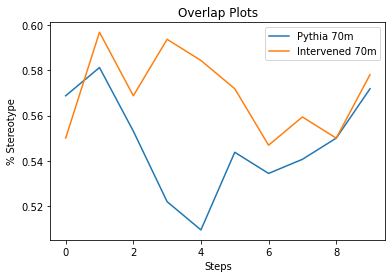

In [9]:
# plot
fig, ax = plt.subplots()
ax.plot(ls_common_pythia_res_70m, label='Pythia 70m')
ax.plot(ls_common_intervened_res_70m, label='Intervened 70m')
ax.set_xlabel('Steps')
ax.set_ylabel('% Stereotype')
ax.set_title('Overlap Plots')
ax.legend()

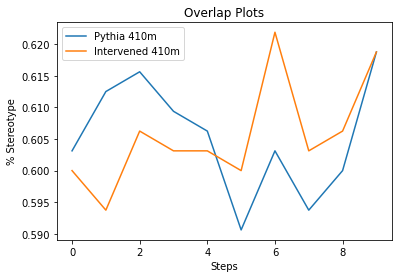

In [10]:
# plot
fig, ax = plt.subplots()
ax.plot(ls_common_pythia_res_410m, label='Pythia 410m')
ax.plot(ls_common_intervened_res_410m, label='Intervened 410m')
ax.set_xlabel('Steps')
ax.set_ylabel('% Stereotype')
ax.set_title('Overlap Plots')
ax.legend()

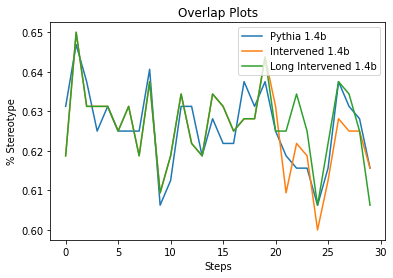

In [11]:
# plot
fig, ax = plt.subplots()
ax.plot(ls_common_pythia_res_1_4b, label='Pythia 1.4b')
ax.plot(ls_common_intervened_res_1_4b, label='Intervened 1.4b')
ax.plot(ls_common_long_intervened_res_1_4b, label='Long Intervened 1.4b')
ax.set_xlabel('Steps')
ax.set_ylabel('% Stereotype')
ax.set_title('Overlap Plots')
ax.legend()

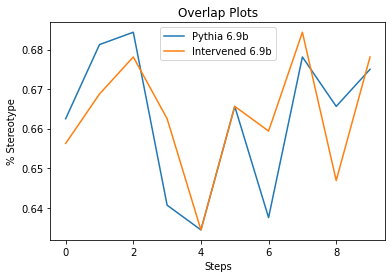

In [12]:
# plot
fig, ax = plt.subplots()
ax.plot(ls_common_pythia_res_6_9b, label='Pythia 6.9b')
ax.plot(ls_common_intervened_res_6_9b, label='Intervened 6.9b')
ax.set_xlabel('Steps')
ax.set_ylabel('% Stereotype')
ax.set_title('Overlap Plots')
ax.legend()

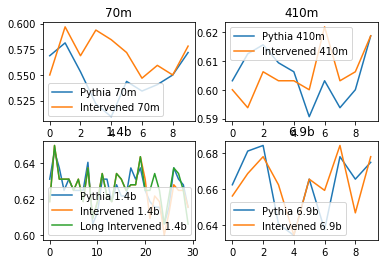

In [13]:
# make 4 subplots in 2x2 grid for all 4 sizes
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(ls_common_pythia_res_70m, label='Pythia 70m')
axs[0, 0].plot(ls_common_intervened_res_70m, label='Intervened 70m')
axs[0, 0].set_title('70m')
axs[0, 0].legend()
axs[0, 1].plot(ls_common_pythia_res_410m, label='Pythia 410m')
axs[0, 1].plot(ls_common_intervened_res_410m, label='Intervened 410m')  
axs[0, 1].set_title('410m')
axs[0, 1].legend()
axs[1, 0].plot(ls_common_pythia_res_1_4b, label='Pythia 1.4b')
axs[1, 0].plot(ls_common_intervened_res_1_4b, label='Intervened 1.4b')
axs[1, 0].plot(ls_common_long_intervened_res_1_4b, label='Long Intervened 1.4b')
axs[1, 0].set_title('1.4b')
axs[1, 0].legend()
axs[1, 1].plot(ls_common_pythia_res_6_9b, label='Pythia 6.9b')
axs[1, 1].plot(ls_common_intervened_res_6_9b, label='Intervened 6.9b')
axs[1, 1].set_title('6.9b')
axs[1, 1].legend()

In [14]:
def preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes, connect=True, normalize=False):
    dict_pythia = {}
    dict_intervention = {}
    dict_long_intervention = {}

    for model_size in model_sizes:
        dict_pythia[model_size] = []
        dict_intervention[model_size] = []
        dict_long_intervention[model_size] = []

    # plot pythia
    for model_size in model_sizes:
        for key in pythia_dict:
            if key[0] == model_size:
                dict_pythia[model_size].append((key[1], pythia_dict[key][task_name]))

    # Sort by step
    for model_size in model_sizes:
        dict_pythia[model_size] = sorted(dict_pythia[model_size], key=lambda x: x[0])

    # normalize x[0] to 1 to 100 %
    if normalize:
        for model_size in model_sizes:
            max_step = dict_pythia[model_size][-1][0]
            dict_pythia[model_size] = [(x[0]/max_step*100, x[1]) for x in dict_pythia[model_size]]

    # plot intervention
    for model_size in model_sizes:
        for key in intervention_dict:
            if key[0] == model_size:
                dict_intervention[model_size].append((key[1], intervention_dict[key][task_name]))

    # Sort by step
    for model_size in model_sizes:
        dict_intervention[model_size] = sorted(dict_intervention[model_size], key=lambda x: x[0])

    # normalize x[0] to 1 to 100 %
    if normalize:
        for model_size in model_sizes:
            max_step = dict_intervention[model_size][-1][0]
            dict_intervention[model_size] = [(x[0]/max_step*100, x[1]) for x in dict_intervention[model_size]]

    # plot long intervention
    if long_intervention_dict is not None:
        for model_size in model_sizes:
            for key in long_intervention_dict:
                if key[0] == model_size:
                    dict_long_intervention[model_size].append((key[1], long_intervention_dict[key][task_name]))

        # Sort by step
        for model_size in model_sizes:
            dict_long_intervention[model_size] = sorted(dict_long_intervention[model_size], key=lambda x: x[0])

        # normalize x[0] to 1 to 100 %
        if normalize:
            for model_size in model_sizes:
                if dict_long_intervention[model_size] != []:
                    max_step = dict_long_intervention[model_size][-1][0]
                    dict_long_intervention[model_size] = [(x[0]/max_step*100, x[1]) for x in dict_long_intervention[model_size]]
                    
    # Find first step where intervened and long_intervened matche pythia in x[0] and choose step before that
    c1 = [0 for _ in range(len(model_sizes))]
    c2 = [0 for _ in range(len(model_sizes))]

    
    for i in range(len(model_sizes)):
        if dict_long_intervention[model_sizes[i]] != []:
            for j in range(len(dict_pythia[model_sizes[i]])):
                if dict_pythia[model_sizes[i]][j][0] >= dict_intervention[model_sizes[i]][0][0]:
                    if dict_pythia[model_sizes[i]][j][0] > dict_intervention[model_sizes[i]][0][0]:
                        c1[i] = j - 1
                    else:
                        c1[i] = j
                    break
            for j in range(len(dict_pythia[model_sizes[i]])):
                if dict_pythia[model_sizes[i]][j][0] >= dict_long_intervention[model_sizes[i]][0][0]:
                    if dict_pythia[model_sizes[i]][j][0] > dict_long_intervention[model_sizes[i]][0][0]:
                        c2[i] = j - 1
                    else:
                        c2[i] = j
                    break
        else:
            for j in range(len(dict_pythia[model_sizes[i]])):
                if dict_pythia[model_sizes[i]][j][0] >= dict_intervention[model_sizes[i]][0][0]:
                    if dict_pythia[model_sizes[i]][j][0] > dict_intervention[model_sizes[i]][0][0]:
                        c1[i] = j - 1
                    else:
                        c1[i] = j
                    break
    
    if connect:
        # Add the point at index c to the beginning of ls_intervened
        # print('Adding point', dict_pythia[c], 'to ls_intervened')
        for i in range(len(model_sizes)):
            dict_intervention[model_sizes[i]] = [dict_pythia[model_sizes[i]][c1[i]]] + dict_intervention[model_sizes[i]]
            if dict_long_intervention[model_sizes[i]] != []:
                dict_long_intervention[model_sizes[i]] = [dict_pythia[model_sizes[i]][c2[i]]] + dict_long_intervention[model_sizes[i]]
    
    print('c1', c1)
    print('c2', c2)
    if not normalize:
        # Keep points where key[0] is greater than dict_pythia[c][0]
        for i in range(len(model_sizes)):
            dict_intervention[model_sizes[i]] = [x for x in dict_intervention[model_sizes[i]] if x[0] > 50000]
            if dict_long_intervention[model_sizes[i]] != []:
                dict_long_intervention[model_sizes[i]] = [x for x in dict_long_intervention[model_sizes[i]] if x[0] > 50000]
            dict_pythia[model_sizes[i]] = [x for x in dict_pythia[model_sizes[i]] if x[0] > 50000]

    return dict_pythia, dict_intervention, dict_long_intervention

In [15]:
def plot_results(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes, save_name, connect=True, normalize=False):
    """
    Args:
        pythia_dict: dict of pythia results
        intervention_dict: dict of intervention results
        long_intervention_dict: dict of long intervention results
        task_name: name of the task
        model_sizes: list of model sizes to plot (In Order)
        save_name: name of the file to save to (Entire path)
        connect: whether to connect the first point of intervened and long intervened to the previous pythia step
        normalize: whether to normalize the x-axis to % of Training Data
    """
    dict_pythia, dict_intervention, dict_long_intervention = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes, connect, normalize)
    print("Processed")
    # plot
    plt.rcParams["figure.figsize"] = (15, 10)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    for i in range(len(model_sizes)):
        updated_size = model_sizes[i].upper()

        plt.plot([x[0] for x in dict_pythia[model_sizes[i]]], [x[1] for x in dict_pythia[model_sizes[i]]], label='Pythia ' + updated_size, color=colors[i])
        plt.plot([x[0] for x in dict_intervention[model_sizes[i]]], [x[1] for x in dict_intervention[model_sizes[i]]], label='Intervention ' + updated_size, linestyle='dotted', color=colors[i])
        if dict_long_intervention[model_sizes[i]] != []:
            plt.plot([x[0] for x in dict_long_intervention[model_sizes[i]]], [x[1] for x in dict_long_intervention[model_sizes[i]]], label='Long Intervention ' + updated_size, linestyle='dashdot', color=colors[i])

    plt.xlabel('% of Training Data')
    plt.ylabel('% Stereotype')
    # Font size
    plt.rcParams.update({'font.size': 15})
    # Line width
    plt.rcParams['lines.linewidth'] = 3
    # x Label and Y Label Font
    plt.rcParams['axes.labelsize'] = 25
    # x and y Ticks Font
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20


    # Legend Font
    plt.rcParams['legend.fontsize'] = 18
    plt.legend()
    # plt.show()
    # Save the plot
    plt.savefig(save_name, format='pdf')

c1 [26, 24]
c2 [0, 24]
Processed


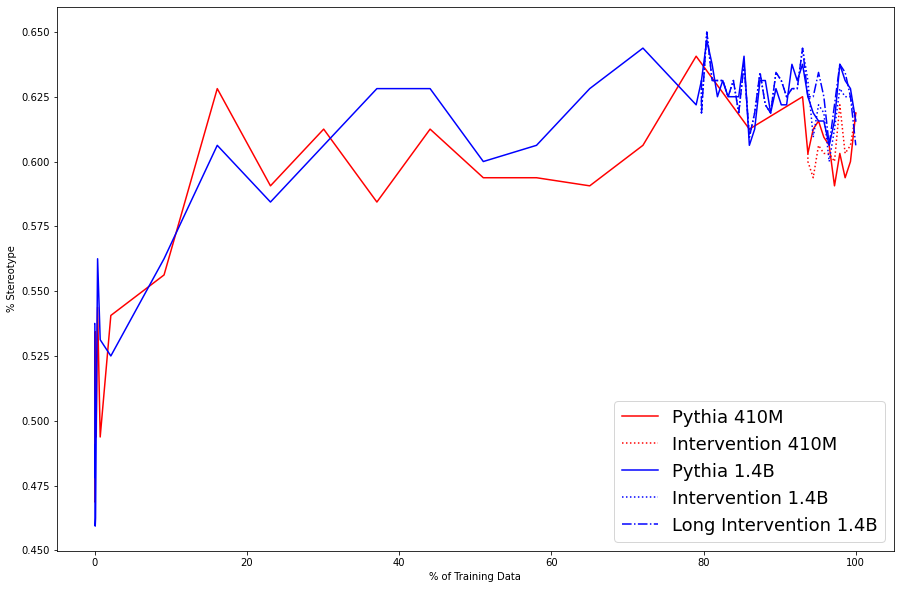

In [16]:
plot_results(pythia_res,
             intervened_res,
             long_intervened_res,
             'crows_pairs_english_gender',
             ['410m', '1.4b'],
             'crowspair_plots/' + 'crows_pairs_english_gender_lesser_steps.pdf', normalize=True)

c1 [26, 26]
c2 [0, 0]
Processed


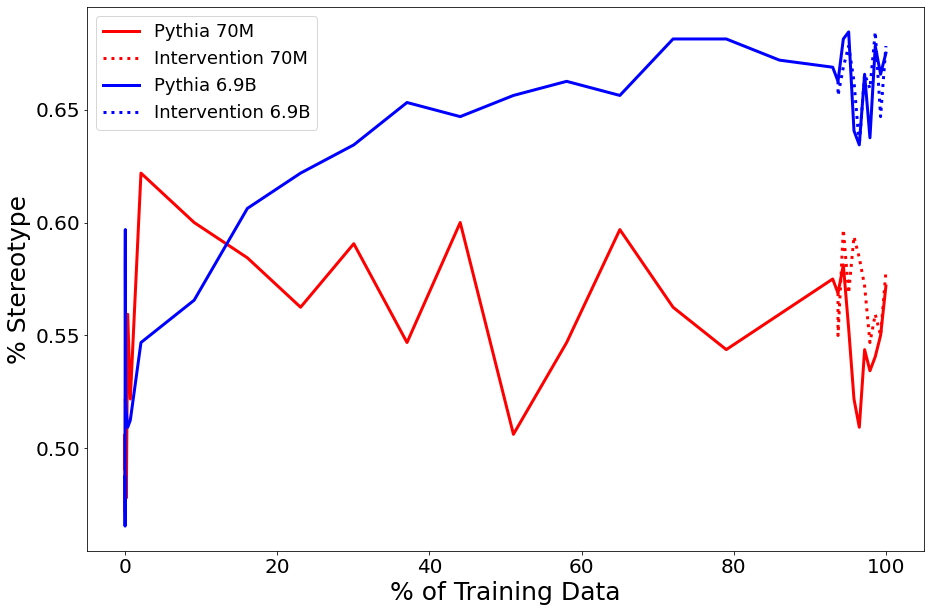

In [17]:
plot_results(pythia_res,
             intervened_res,
             long_intervened_res,
             'crows_pairs_english_gender',
             ['70m','6.9b'],
             'crowspair_plots/' + 'crows_pairs_english_gender_more_steps.pdf', normalize=True)

c1 [26, 26, 24, 26]
c2 [0, 0, 24, 0]
Processed


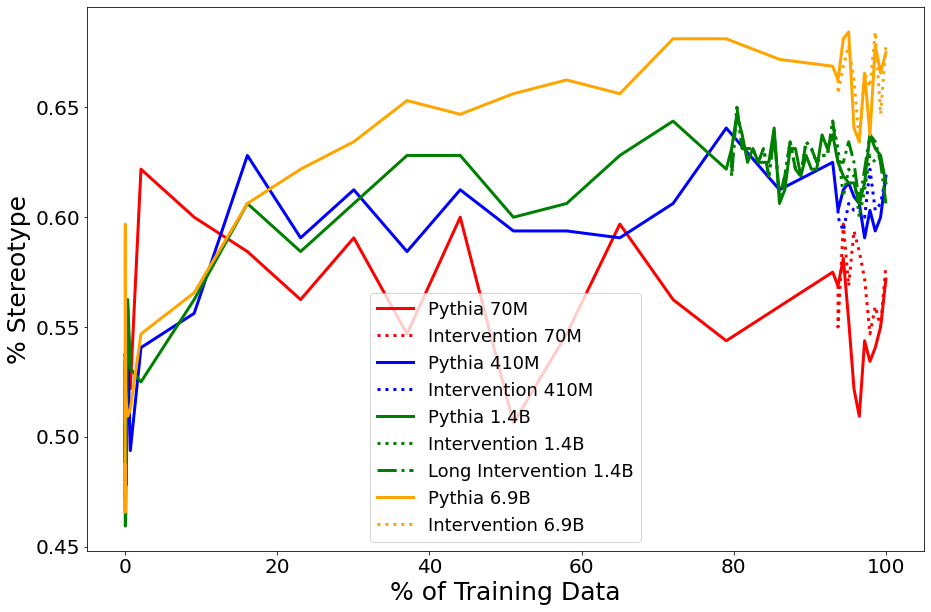

In [18]:
plot_results(pythia_res,
             intervened_res,
             long_intervened_res,
             'crows_pairs_english_gender',
             ['70m', '410m', '1.4b','6.9b'],
             'crowspair_plots/' + 'crows_pairs_english_gender_more_steps.pdf', normalize=True)

In [19]:
def plot_results_shared_axes(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes, save_name, connect=True, normalize=False):
    """
    Args:
        pythia_dict: dict of pythia results
        intervention_dict: dict of intervention results
        long_intervention_dict: dict of long intervention results
        task_name: name of the task
        model_sizes: 2D list with each sublist containing model sizes to plot (In Order)
        save_name: name of the file to save to (Entire path)
        connect: whether to connect the first point of intervened and long intervened to the previous pythia step
        normalize: whether to normalize the x-axis to % of Training Data
    """
    dict_pythia_1, dict_intervention_1, dict_long_intervention_1 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[0], connect, normalize)
    dict_pythia_2, dict_intervention_2, dict_long_intervention_2 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[1], connect, normalize)

    # plot
    plt.rcParams["figure.figsize"] = (30, 10)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Create 2 subplots sharing y axis
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    for i in range(len(model_sizes[0])):
        ax1.plot([x[0] for x in dict_pythia_1[model_sizes[0][i]]], [x[1] for x in dict_pythia_1[model_sizes[0][i]]], label='Pythia ' + model_sizes[0][i].upper(), color=colors[i])
        ax1.plot([x[0] for x in dict_intervention_1[model_sizes[0][i]]], [x[1] for x in dict_intervention_1[model_sizes[0][i]]], label='Intervention ' + model_sizes[0][i].upper(), linestyle='dotted', color=colors[i])
        if dict_long_intervention_1[model_sizes[0][i]] != []:
            ax1.plot([x[0] for x in dict_long_intervention_1[model_sizes[0][i]]], [x[1] for x in dict_long_intervention_1[model_sizes[0][i]]], label='Long Intervention ' + model_sizes[0][i].upper(), linestyle='dashdot', color=colors[i])
    
    for i in range(len(model_sizes[1])):
        ax2.plot([x[0] for x in dict_pythia_2[model_sizes[1][i]]], [x[1] for x in dict_pythia_2[model_sizes[1][i]]], label='Pythia ' + model_sizes[1][i].upper(), color=colors[i])
        ax2.plot([x[0] for x in dict_intervention_2[model_sizes[1][i]]], [x[1] for x in dict_intervention_2[model_sizes[1][i]]], label='Intervention ' + model_sizes[1][i].upper(), linestyle='dotted', color=colors[i])
        if dict_long_intervention_2[model_sizes[1][i]] != []:
            ax2.plot([x[0] for x in dict_long_intervention_2[model_sizes[1][i]]], [x[1] for x in dict_long_intervention_2[model_sizes[1][i]]], label='Long Intervention ' + model_sizes[1][i].upper(), linestyle='dashdot', color=colors[i])

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('% Stereotype')
    ax2.set_xlabel('Steps')

    # Show Both Legends
    ax1.legend()
    ax2.legend()

    # Font size
    plt.rcParams.update({'font.size': 15})
    # Line width
    plt.rcParams['lines.linewidth'] = 3
    plt.legend()
    # plt.show()
    # Save the plot
    plt.savefig(save_name, format='pdf')

c1 [26, 24]
c2 [0, 24]
c1 [26, 26]
c2 [0, 0]


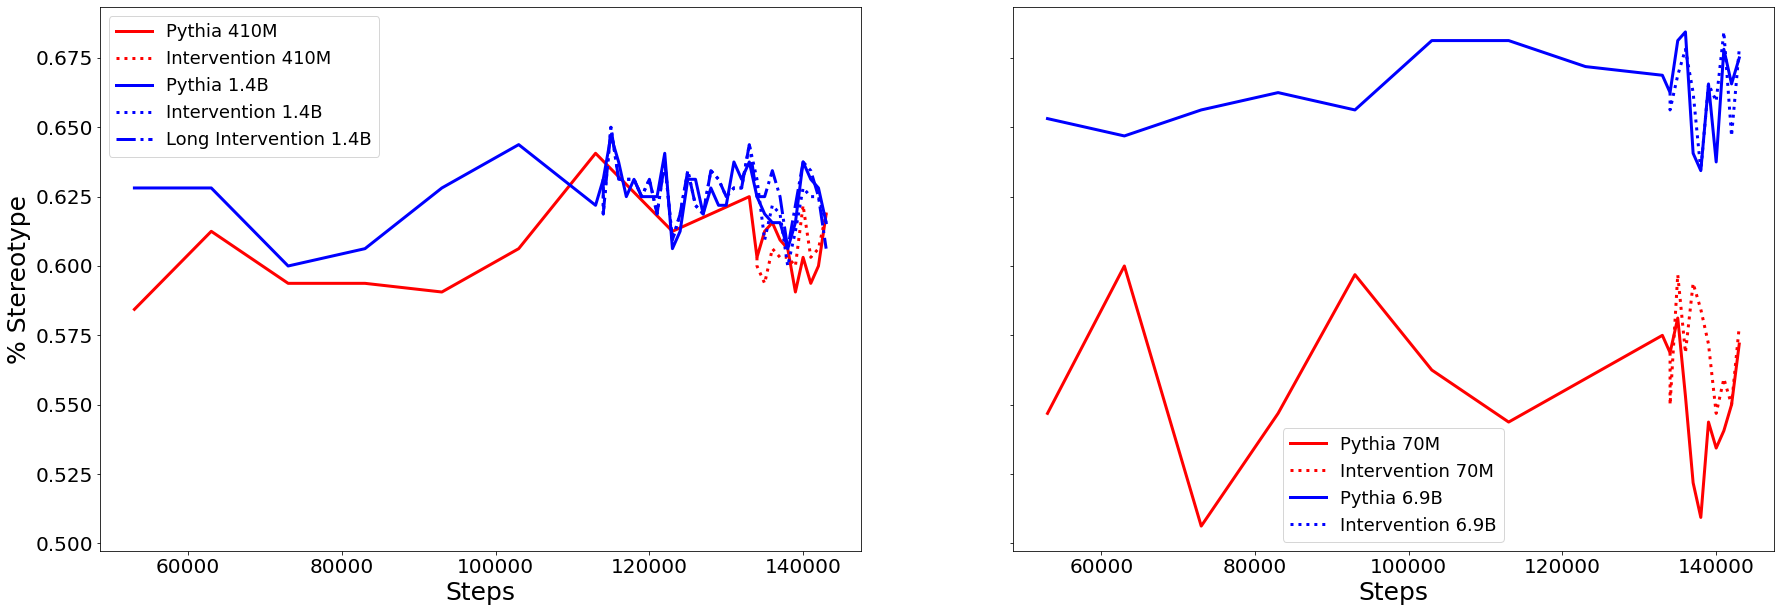

In [20]:
plot_results_shared_axes(pythia_res,
             intervened_res,
             long_intervened_res,
             'crows_pairs_english_gender',
                [['410m', '1.4b'], ['70m','6.9b']],
             'crowspair_plots/' + 'crows_pairs_english_gender_shared_axes.pdf')